This model of Exp E is from Jan 2022. 

It models the glacier described in Pattyn (...) as a deformed mesh. Some ingenuity is necessary for this to work, so maybe there will be another version necessary. Obe that just uses particles.

# Basic python imports and model settings

In [7]:
from underworld import function as fn
import underworld as uw

import underworld.visualisation as vis

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

maxY = maxX = 100.

minY = minX = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

res = 25

print("res: " + str(res))
    
cell_height = maxY / res
cell_width = maxX / res

res: 25


# The mesh

In [8]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(res, res),
                                minCoord=(minX, minY),
                                maxCoord=(maxX, maxY),
                                periodic=[False, False])

submesh = mesh.subMesh

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

	Global element size: 25x25
	Local offset of rank 0: 0x0
	Local range of rank 0: 25x25


# Read topo-information from file

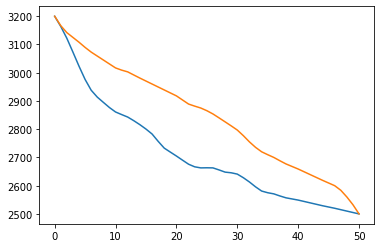

In [9]:
topo = np.genfromtxt("topo.csv")
topo_base = topo[:, 0:-2]
topo_surf = topo[:, 0:-1]
topo_surf = np.delete(topo_surf, obj=1, axis=1)

pyplot.plot(topo_base[:,-1])
pyplot.plot(topo_surf[:,-1])
pyplot.show()

## Deform the mesh


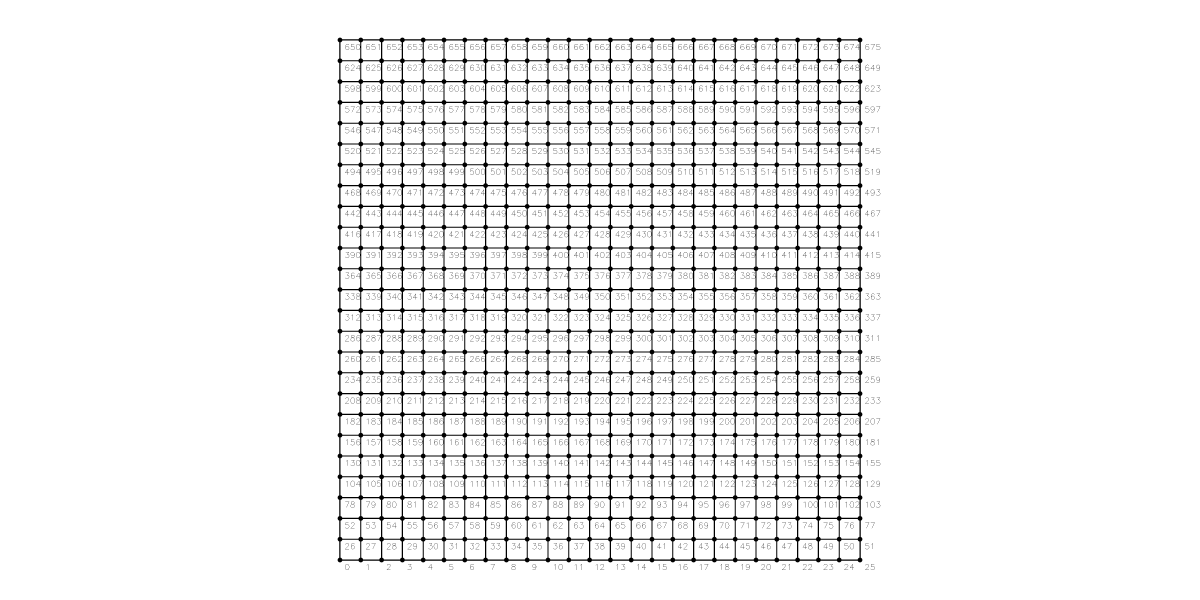

In [10]:
figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh, nodeNumbers=True))
figMesh.show()


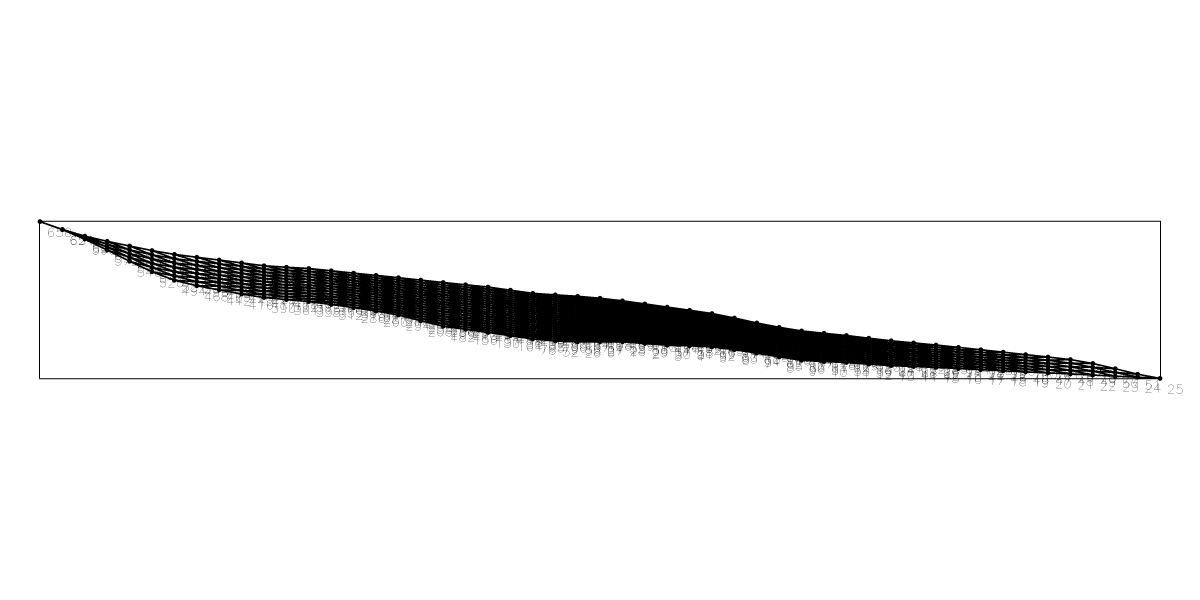

In [11]:
with mesh.deform_mesh():

    for i in range (topo_base.shape[0]):

        x = topo_base[i, 0]
        y_base = topo_base[i, 1]
        y_surf = topo_surf[i, 1]
        
        # find nodenumbers
        if (i < res):
            nb_of_nodes = i + 1
            
            # create list of nodes
            nodelist = []
            startnode = (res - i) * (res+1)
            
            for j in range(0, nb_of_nodes):
                nodelist.append(startnode + j*(res+2))
            
            # create list of y-positions
            poslist = []
            
            diff = (y_surf - y_base) / float(len(nodelist))
            
            for j in range(len(nodelist)):
                poslist.append(j*diff + y_base)
            
            for k, j in enumerate(nodelist):
                mesh.data[j,0] = x
                mesh.data[j,1] = poslist[k]
        else:
            nb_of_nodes = (2*res + 1) - i
            
            # create list of nodes
            nodelist = []
            startnode = i - res
            
            for j in range(0, nb_of_nodes):
                nodelist.append(startnode + j*(res+2))
            
            # create list of y-positions
            poslist = []
            
            diff = (y_surf - y_base) / float(len(nodelist))
            
            for j in range(len(nodelist)):
                poslist.append(j*diff + y_base)
            
            for k, j in enumerate(nodelist):
                mesh.data[j,0] = x
                mesh.data[j,1] = poslist[k]            

figMesh.show()


# A dummy swarm
for evaluation

In [17]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# Initialise the 'materialVariable' data to represent different materials.
materialV = 0  	# ice, isotropic
materialR = 1   # rock

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
#swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=5 )

swarm.populate_using_layout(layout=swarmLayout)

measurementSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(measurementSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm, velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=measurementSwarm, velocityField=velocityField, order=2)

# Boundary conditions

In [18]:
botWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MinJ_VertexSet"]
surfWalls = mesh.specialSets["MaxI_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

# Dirichlet
condition = uw.conditions.DirichletCondition(variable = velocityField, indexSetsPerDof=(botWalls, botWalls))

velocityField.data[:] = [0., 0.]

In [19]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

# Viscosity, density, buoyancy

In [20]:
minViscosityIceFn = fn.misc.constant(1e+7 / 31556926)
maxViscosityIceFn = fn.misc.constant(1e+16 / 31556926)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFn = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFn = fn.misc.constant( ice_density )

z_hat = (0., -1.)
buoyancyFn = densityFn * z_hat * 9.81

In [21]:
devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

# Solver

In [22]:
stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=condition,
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

#solver.set_inner_method("lu")
#solver.set_inner_method("superlu")
solver.set_inner_method("mumps")
#solver.set_inner_method("superludist")
#solver.set_inner_method("mg")
#solver.set_inner_method("nomg")

# solver.set_penalty(1.0e21 / 31556926)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3
#penalty = 1e3
#solver.set_penalty(penalty)
#nl_tol = 2.e1
nl_tol = 1.e-4

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=surfWalls)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=surfWalls)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    exec_time = time.time()
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    #solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    exec_time = time.time() - exec_time

    # print full stats to a file
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)
    
print (f'Solving took: {exec_time} seconds')

In func WeightsCalculator_CalculateAll(): for swarm "X3IN570Z__swarm"
	done 33% (209 cells)...
	done 67% (417 cells)...
	done 100% (625 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "X3IN570Z__swarm"
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Calibration pressure 45539.72199869516
Calibration pressure 33179.72081824986
Calibration pressure 34735.24866753468
Linear solver (H95OJUJW__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.001372 secs / 1 its
  Pressure Solve:         = 0.5681 secs / 553 its
  Final V Solve:          = 0.0008698 secs / 1 its

  Total BSSCR Linear solve time: 0.578277 seconds

Linear solver (H95OJUJW__system-execute), solution time 5.793693e-01 (secs)
Non linear solver - iteration 1
Linear solver (H95OJUJW__system-execute) 

BSSCR -- Block 

Non linear solver - Residual 3.93853762e-02; Tolerance 1.0000e-04 - Not converged - 4.720102e+00 (secs)

Non linear solver - iteration 12
Linear solver (H95OJUJW__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.002241 secs / 1 its
  Pressure Solve:         = 0.2836 secs / 227 its
  Final V Solve:          = 0.001085 secs / 1 its

  Total BSSCR Linear solve time: 0.298062 seconds

Linear solver (H95OJUJW__system-execute), solution time 2.984478e-01 (secs)
Calibration pressure 28086.129529604877
Calibration pressure 28098.66669004702In func SystemLinearEquations_NonLinearExecute: Iteration 12 of 500 - Residual 0.026439 - Tolerance = 0.0001
Non linear solver - Residual 2.64386253e-02; Tolerance 1.0000e-04 - Not converged - 5.110028e+00 (secs)

Non linear solver - iteration 13
Linear solver (H95OJUJW__system-execute) 

BSSCR -- Blo

  Pressure Solve:         = 0.2931 Calibration pressure 28114.02932718111
secs / 227 its
  Final V Solve:          = 0.0009237 secs / 1 its

  Total BSSCR Linear solve time: 0.305778 seconds

Linear solver (H95OJUJW__system-execute), solution time 3.061542e-01 (secs)
In func SystemLinearEquations_NonLinearExecute: Iteration 23 of 500 - Residual 0.00030909 - Tolerance = 0.0001
Non linear solver - Residual 3.09087506e-04; Tolerance 1.0000e-04 - Not converged - 9.197409e+00 (secs)

Non linear solver - iteration 24
Linear solver (H95OJUJW__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.001399 secs / 1 its
  Pressure Solve:         = 0.2984 secs / 227 its
  Final V Solve:          = 0.000901 secs / 1 its

  Total BSSCR Linear solve time: 0.308464 seconds

Linear solver (H95OJUJW__system-execute), solution time 3.088172e-01 (secs)
C

In [ ]:
figStress = vis.Figure(figsize=(1200,600))
#figStress.append( vis.objects.Mesh(mesh))
figStress.append(vis.objects.Points(swarm, shearStressFn, pointSize=1.0, colourBar=True, ))#fn_mask = materialVariable))
figStress.show()

In [29]:
pos = mesh.data[botWalls]
pos[:,0] += 50.
shearstress = devStressFn.evaluate(pos)[:,2]
ind = np.argsort(mesh.data[botWalls, 0])
pyplot.plot(shearstress[ind])
pyplot.show()

ValueError: Issue utilising function of class '_gradient' constructed at:

0- 0:/tmp/ipykernel_69/798775625.py:1
    strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)

Error message:
FeVariable derivative interpolation at location (5050, 2500) does not appear to be valid.
Location is probably outside local domain.

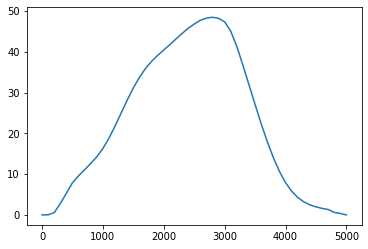

In [25]:
velocity = velocityField.evaluate(mesh.data[surfWalls])[:,0]
ind = np.argsort(mesh.data[surfWalls, 0])
pyplot.plot(mesh.data[surfWalls][ind, 0], velocityField.data[surfWalls][ind, 0])
pyplot.show()

# Output

In [ ]:
#### Filename
outputFile = os.path.join(os.path.abspath("."), "jla"+"1c"+ str(systemDim).zfill(3) + ".csv")
print(outputFile)

#### Smooth the stress
meshStressTensor = uw.mesh.MeshVariable(mesh, 6)
projectorStress = uw.utils.MeshVariable_Projection( meshStressTensor, devStressFn, type=0 )
projectorStress.solve()

#### Smooth the velocity
meshVelocity = uw.mesh.MeshVariable(mesh, 3)
projectorV = uw.utils.MeshVariable_Projection( meshVelocity, velocityField, type=0 )
projectorV.solve()

#### Smooth the pressure
meshP = uw.mesh.MeshVariable(mesh, 1)
projectorP = uw.utils.MeshVariable_Projection( meshP, pressureField, type=0 )
projectorP.solve()

#### Points
xpos = np.arange(start=0, stop=int(resX+1)) * maxX / resX
zpos = np.arange(start=0, stop=int(resZ+1)) * maxZ / resZ

xz = np.array(np.meshgrid(xpos, zpos)).T.reshape(-1,2)

sub = cell_height
add = cell_height

surf_y = z_bed_function.evaluate(xz)
surf_pos = np.insert(xz, 1, maxY - sub, axis=1 )

base_pos = np.insert(xz, 1, add, axis=1 )
base_pos[:, 1] = surf_y[:,0]

#### Get the surface velocity
#vxs = meshVelocity.evaluate(surf_pos).transpose()[0]
#vys = meshVelocity.evaluate(surf_pos).transpose()[1]
#vzs = meshVelocity.evaluate(surf_pos).transpose()[2]
vxs = velocityField.evaluate(surf_pos).transpose()[0]
vys = velocityField.evaluate(surf_pos).transpose()[1]
vzs = velocityField.evaluate(surf_pos).transpose()[2]

vtots = np.sqrt( vxs*vxs + vys*vys + vzs*vzs )

#### Get the basal velocity
#vxb = meshVelocity.evaluate(base_pos).transpose()[0]
#vyb = meshVelocity.evaluate(base_pos).transpose()[1]
#vzb = meshVelocity.evaluate(base_pos).transpose()[2]
vxb = velocityField.evaluate(base_pos).transpose()[0]
vyb = velocityField.evaluate(base_pos).transpose()[1]
vzb = velocityField.evaluate(base_pos).transpose()[2]

vtotb = np.sqrt( vxb*vxb + vyb*vyb + vzb*vzb )

#### Get the pressure
#P = meshP.evaluate(base_pos).squeeze()
P = pressureField.evaluate(base_pos).squeeze()

#### Get the shearstress
sxz = meshStressTensor.evaluate(base_pos).squeeze()[:,3]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

sxy = meshStressTensor.evaluate(base_pos).squeeze()[:,4]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

#### only indices where z ~ 0.25
ind = np.where(np.logical_and(xz[:,1] > 0.22 * maxZ , xz[:,1] < 0.28 * maxZ))

#### plot pressure from grid / theoretical / difference
print("DeltaP")
#pyplot.plot((maxY - base_ypos[:]) * 9.81 * 910, color='red')
smoothed_2dg = savgol_filter(P[ind], window_length = 7, polyorder = 2)
#pyplot.plot(P[ind], color='blue')
pyplot.plot(P[ind] - (maxY - base_pos[ind, 1].squeeze()) * 9.81 * 910., color='green')
pyplot.plot(smoothed_2dg, color='black')
pyplot.show()

#### plot vx at surface
print("vxs")
smoothed_2dg = savgol_filter(vxs[ind], window_length = 7, polyorder = 2)
#pyplot.plot(vxs[ind], color='red')
pyplot.plot(smoothed_2dg, color='black')
pyplot.show()

### plot shear stress
print("Shear stress")
smoothed_2dg = savgol_filter(sxz[ind] / 1000, window_length = 7, polyorder = 2)
#pyplot.plot (sxz[ind] / 1000., color='red')
pyplot.plot (smoothed_2dg, color='black')
pyplot.show ()

#### output to file
with open(outputFile, "w") as text_file:
    
    for i in range(0, resX+1):
        
        # Ausgabe [x] [y]
        textline = str("{:.7f}".format(surf_pos[i, 0] / maxX)) + "\t" \
        + str("{:.7f}".format(surf_pos[i, 2] / maxZ)) + "\t"
        
        #Ausgabe Geschwindigkeiten Surface[vx] [vy] [vz]
        textline += str("{:.7f}".format(vxs[i])) + "\t" + str("{:.7f}".format(vzs[i])) \
        + "\t" + str("{:.7f}".format(vys[i])) + "\t"
        
        #Ausgabe Geschwindigkeiten Basis [vx] [vy]
        textline += str("{:.7f}".format(vxb[i])) + "\t" + str("{:.7f}".format(vzb[i])) + "\t"
        
        # Scherspannung Basis Tensoren [Txz] [Tyz]
        textline += str("{:.7f}".format(sxz[i] / 1000.)) + "\t" + str("{:.7f}".format(sxy[i] / 1000.)) + "\t"
        
        # Ausgabe delta p
        textline += str("{:.7f}".format(float(P[i]) - float((maxY - base_pos[i, 1]) * 9.81 * 910 / 1000))) + "\n"

        text_file.write(textline)